# Step 3: Combination and Filling Gaps

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
FEATURES_PATH = BASE_PATH / 'data' / 'processed' / 'windowed_features'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'tables'
FIGURES_PATH = BASE_PATH / 'outputs' / 'figures'
COMBINED_PATH = BASE_PATH / 'data' / 'processed' / 'combined'
COMBINED_PATH.mkdir(parents=True, exist_ok=True)

In [2]:
# 3.1 Load windowed features
wesad_df = pd.read_csv(FEATURES_PATH / 'WESAD_windowed_features.csv')
epm_df = pd.read_csv(FEATURES_PATH / 'EPM4_windowed_features.csv')
physionet_df = pd.read_csv(FEATURES_PATH / 'PhysioNet_windowed_features.csv')

print(f"WESAD: {len(wesad_df)} windows")
print(f"EPM-E4: {len(epm_df)} windows")
print(f"PhysioNet: {len(physionet_df)} windows")

WESAD: 1305 windows
EPM-E4: 2510 windows
PhysioNet: 6696 windows


In [3]:
# Check current feature names
print("WESAD columns:", wesad_df.columns.tolist())
print("\nEPM-E4 columns:", epm_df.columns.tolist())
print("\nPhysioNet columns:", physionet_df.columns.tolist())

WESAD columns: ['window_id', 'bvp_mean', 'bvp_std', 'bvp_min', 'bvp_max', 'bvp_range', 'hr_mean', 'hr_std', 'hrv_rmssd', 'hrv_sdnn', 'hrv_pnn50', 'hrv_lf_hf_ratio', 'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'eda_range', 'eda_scr_count', 'eda_scr_amp_mean', 'eda_tonic_mean', 'eda_phasic_mean', 'eda_slope', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_range', 'temp_slope', 'acc_mag_mean', 'acc_mag_std', 'acc_mag_min', 'acc_mag_max', 'acc_x_mean', 'acc_y_mean', 'acc_z_mean', 'acc_x_std', 'acc_y_std', 'acc_z_std', 'acc_sma', 'acc_energy', 'acc_entropy', 'subject_id', 'dataset', 'label', 'timestamp_start', 'timestamp_end']

EPM-E4 columns: ['window_id', 'bvp_mean', 'bvp_std', 'bvp_min', 'bvp_max', 'bvp_range', 'hr_mean', 'hr_std', 'hrv_rmssd', 'hrv_sdnn', 'hrv_pnn50', 'hrv_lf_hf_ratio', 'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'eda_range', 'eda_scr_count', 'eda_scr_amp_mean', 'eda_tonic_mean', 'eda_phasic_mean', 'eda_slope', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 

In [4]:
# 3.1 Feature Normalization - Verify unified naming
# Features are already using unified naming from extraction
# Create feature mapping documentation

feature_mapping = {
    'bvp_mean': 'BVP mean amplitude',
    'bvp_std': 'BVP standard deviation',
    'bvp_min': 'BVP minimum',
    'bvp_max': 'BVP maximum',
    'bvp_range': 'BVP range (max-min)',
    'hr_mean': 'Heart rate mean',
    'hr_std': 'Heart rate std',
    'hr_min': 'Heart rate minimum',
    'hr_max': 'Heart rate maximum',
    'hr_range': 'Heart rate range',
    'hrv_rmssd': 'HRV RMSSD from IBI',
    'eda_mean': 'EDA mean',
    'eda_std': 'EDA standard deviation',
    'eda_min': 'EDA minimum',
    'eda_max': 'EDA maximum',
    'eda_range': 'EDA range',
    'eda_slope': 'EDA linear slope',
    'eda_scr_peaks': 'Number of SCR peaks',
    'eda_scr_amp_mean': 'Mean SCR amplitude',
    'eda_phasic_mean': 'Phasic component mean',
    'eda_tonic_mean': 'Tonic component mean',
    'temp_mean': 'Skin temperature mean',
    'temp_std': 'Skin temperature std',
    'temp_min': 'Skin temperature minimum',
    'temp_max': 'Skin temperature maximum',
    'temp_range': 'Skin temperature range',
    'temp_slope': 'Temperature slope',
    'acc_x_mean': 'ACC X-axis mean',
    'acc_y_mean': 'ACC Y-axis mean',
    'acc_z_mean': 'ACC Z-axis mean',
    'acc_x_std': 'ACC X-axis std',
    'acc_y_std': 'ACC Y-axis std',
    'acc_z_std': 'ACC Z-axis std',
    'acc_mag_mean': 'ACC magnitude mean',
    'acc_mag_std': 'ACC magnitude std',
    'acc_sma': 'Signal Magnitude Area',
    'acc_energy': 'ACC energy',
    'acc_entropy': 'ACC entropy'
}

mapping_df = pd.DataFrame([
    {'feature': k, 'description': v, 'signal_type': k.split('_')[0].upper()}
    for k, v in feature_mapping.items()
])
mapping_df.to_csv(OUTPUT_PATH / 'feature_mapping_table.csv', index=False)
print(f"Feature mapping saved: {len(mapping_df)} features documented")

Feature mapping saved: 38 features documented


In [5]:
# 3.2 Label Standardization
# Check current labels per dataset
print("WESAD labels:", wesad_df['label'].unique())
print("EPM-E4 labels:", epm_df['label'].unique())
print("PhysioNet labels:", physionet_df['label'].unique())

WESAD labels: ['Baseline' 'Stress' 'Amusement']
EPM-E4 labels: ['Emotion']
PhysioNet labels: ['Stress' 'Aerobic' 'Anaerobic']


In [6]:
# Standardize labels
label_mapping = {
    # WESAD
    'baseline': 'Baseline',
    'Baseline': 'Baseline',
    'stress': 'Stress',
    'Stress': 'Stress',
    'amusement': 'Amusement',
    'Amusement': 'Amusement',
    # EPM-E4 emotions
    'ANGER': 'Anger',
    'Anger': 'Anger',
    'SADNESS': 'Sadness',
    'Sadness': 'Sadness',
    'HAPPINESS': 'Happiness',
    'Happiness': 'Happiness',
    'FEAR': 'Fear',
    'Fear': 'Fear',
    # PhysioNet
    'Aerobic': 'Aerobic',
    'aerobic': 'Aerobic',
    'Anaerobic': 'Anaerobic',
    'anaerobic': 'Anaerobic'
}

wesad_df['label'] = wesad_df['label'].map(lambda x: label_mapping.get(x, x))
epm_df['label'] = epm_df['label'].map(lambda x: label_mapping.get(x, x))
physionet_df['label'] = physionet_df['label'].map(lambda x: label_mapping.get(x, x))

print("After standardization:")
print("WESAD:", wesad_df['label'].unique())
print("EPM-E4:", epm_df['label'].unique())
print("PhysioNet:", physionet_df['label'].unique())

After standardization:
WESAD: ['Baseline' 'Stress' 'Amusement']
EPM-E4: ['Emotion']
PhysioNet: ['Stress' 'Aerobic' 'Anaerobic']


In [7]:
# 3.3 Dataset Combination
# Add dataset source if not present
if 'dataset' not in wesad_df.columns:
    wesad_df['dataset'] = 'WESAD'
if 'dataset' not in epm_df.columns:
    epm_df['dataset'] = 'EPM-E4'
if 'dataset' not in physionet_df.columns:
    physionet_df['dataset'] = 'PhysioNet'

# Concatenate all datasets
combined_df = pd.concat([wesad_df, epm_df, physionet_df], ignore_index=True)
print(f"Combined dataset: {len(combined_df)} windows")
print(f"Subjects: {combined_df['subject_id'].nunique()}")
print(f"Features: {len([c for c in combined_df.columns if c not in ['subject_id', 'dataset', 'window_id', 'timestamp_start', 'timestamp_end', 'label']])}")

Combined dataset: 10511 windows
Subjects: 96
Features: 40


In [8]:
# Label distribution
label_dist = combined_df['label'].value_counts()
label_dist_df = pd.DataFrame({
    'label': label_dist.index,
    'count': label_dist.values,
    'percentage': (label_dist.values / len(combined_df) * 100).round(2)
})
print("\nLabel Distribution:")
print(label_dist_df.to_string(index=False))

# Save label distribution
label_dist_df.to_csv(OUTPUT_PATH / 'label_distribution.csv', index=False)


Label Distribution:
    label  count  percentage
   Stress   3322       31.60
  Emotion   2510       23.88
  Aerobic   2143       20.39
Anaerobic   1620       15.41
 Baseline    707        6.73
Amusement    209        1.99


In [9]:
# Label distribution by dataset
label_by_dataset = combined_df.groupby(['dataset', 'label']).size().unstack(fill_value=0)
print("\nLabel distribution by dataset:")
print(label_by_dataset)


Label distribution by dataset:
label      Aerobic  Amusement  Anaerobic  Baseline  Emotion  Stress
dataset                                                            
EPM-E4           0          0          0         0     2510       0
PhysioNet     2143          0       1620         0        0    2933
WESAD            0        209          0       707        0     389


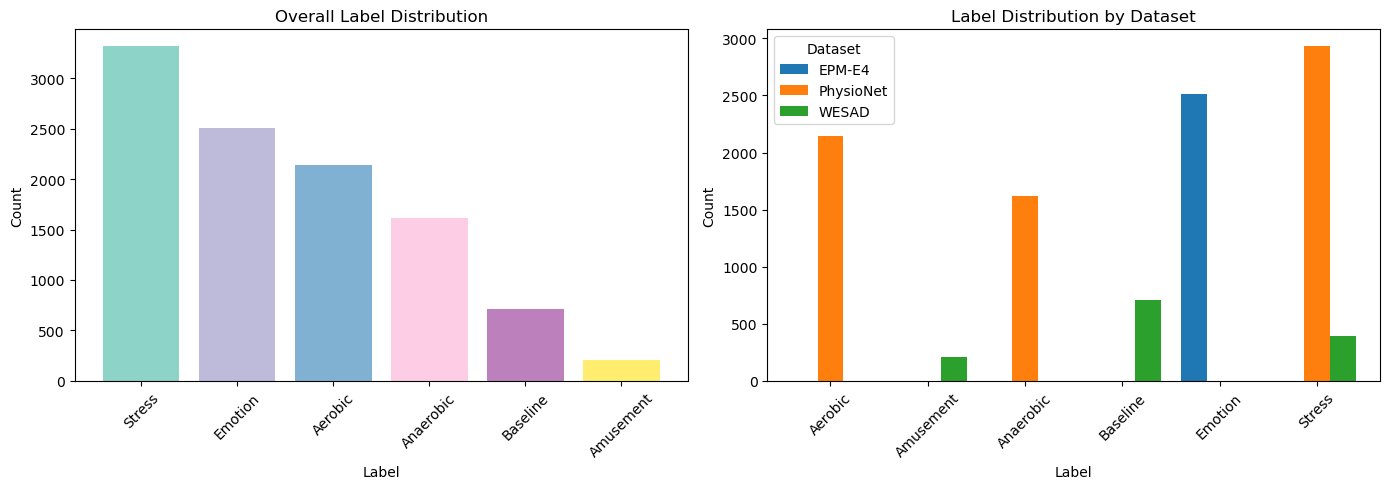

Saved: /home/alvaro-ibarra/smartwatch-stress-detection/outputs/figures/label_distribution.png


In [10]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
colors = plt.cm.Set3(np.linspace(0, 1, len(label_dist)))
axes[0].bar(label_dist.index, label_dist.values, color=colors)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Label Distribution')
axes[0].tick_params(axis='x', rotation=45)

# Distribution by dataset
label_by_dataset.T.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Label Distribution by Dataset')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Dataset')

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_PATH / 'label_distribution.png'}")

In [11]:
# 3.4 Missing Value Analysis
metadata_cols = ['subject_id', 'dataset', 'window_id', 'timestamp_start', 'timestamp_end', 'label']
feature_cols = [c for c in combined_df.columns if c not in metadata_cols]

# Count missing values per feature
missing_before = combined_df[feature_cols].isnull().sum()
missing_pct = (missing_before / len(combined_df) * 100).round(2)

missing_analysis = pd.DataFrame({
    'feature': missing_before.index,
    'missing_count': missing_before.values,
    'missing_pct': missing_pct.values
}).sort_values('missing_count', ascending=False)

print(f"Total windows: {len(combined_df)}")
print(f"Features with missing values: {(missing_before > 0).sum()}")
print(f"\nTop 10 features with missing values:")
print(missing_analysis[missing_analysis['missing_count'] > 0].head(10).to_string(index=False))

Total windows: 10511
Features with missing values: 2

Top 10 features with missing values:
        feature  missing_count  missing_pct
hrv_lf_hf_ratio          10511       100.00
        hr_mean              1         0.01


In [15]:
# Replace infinite values with NaN
combined_df[feature_cols] = combined_df[feature_cols].replace([np.inf, -np.inf], np.nan)

# Total missing values
total_missing_before = combined_df[feature_cols].isnull().sum().sum()
print(f"Total missing values before imputation: {total_missing_before}")

Total missing values before imputation: 10512


In [16]:
# 3.4 KNN Imputation
print("Applying KNN imputation (k=5)...")

# Drop features with 100% missing (cannot be imputed)
cols_to_drop = [c for c in feature_cols if combined_df[c].isnull().all()]
if cols_to_drop:
    print(f"Dropping columns with 100% missing: {cols_to_drop}")
    combined_df = combined_df.drop(columns=cols_to_drop)
    feature_cols = [c for c in feature_cols if c not in cols_to_drop]

# Prepare data for imputation
X = combined_df[feature_cols].copy()

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

# Update dataframe
combined_df[feature_cols] = X_imputed

# Verify
total_missing_after = combined_df[feature_cols].isnull().sum().sum()
print(f"Total missing values after imputation: {total_missing_after}")

Applying KNN imputation (k=5)...
Dropping columns with 100% missing: ['hrv_lf_hf_ratio']
Total missing values after imputation: 0


In [17]:
# Imputation validation: create synthetic missing and evaluate
# Use a subset of complete data to test imputation accuracy
np.random.seed(42)

# Get complete rows
complete_mask = ~combined_df[feature_cols].isnull().any(axis=1)
complete_data = combined_df.loc[complete_mask, feature_cols].copy()

if len(complete_data) > 1000:
    # Sample for validation
    sample_idx = np.random.choice(complete_data.index, size=1000, replace=False)
    validation_data = complete_data.loc[sample_idx].copy()
    
    # Create synthetic missing (10% of values)
    mask = np.random.random(validation_data.shape) < 0.1
    validation_with_missing = validation_data.copy()
    validation_with_missing[mask] = np.nan
    
    # Impute
    imputer_val = KNNImputer(n_neighbors=5)
    imputed_values = imputer_val.fit_transform(validation_with_missing)
    
    # Calculate error on imputed values only
    original_values = validation_data.values[mask]
    imputed_vals = imputed_values[mask]
    
    mae = np.mean(np.abs(original_values - imputed_vals))
    rmse = np.sqrt(np.mean((original_values - imputed_vals) ** 2))
    
    print(f"Imputation Validation (on synthetic missing):")
    print(f"  MAE: {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  Imputed values: {mask.sum()}")
else:
    print("Not enough complete data for validation")
    mae, rmse = np.nan, np.nan

Imputation Validation (on synthetic missing):
  MAE: 13.7378
  RMSE: 54.2795
  Imputed values: 3836


In [18]:
# Save imputation report
imputation_report = f"""Missing Value Imputation Report
================================

Total windows: {len(combined_df)}
Total features: {len(feature_cols)}

Before Imputation:
  Total missing values: {total_missing_before}
  Features with missing: {(missing_before > 0).sum()}

After Imputation (KNN, k=5):
  Total missing values: {total_missing_after}

Imputation Validation:
  Method: Synthetic missing (10%) on complete data
  MAE: {mae:.4f}
  RMSE: {rmse:.4f}
"""

with open(OUTPUT_PATH / 'missing_value_analysis.txt', 'w') as f:
    f.write(imputation_report)
print(imputation_report)

Missing Value Imputation Report

Total windows: 10511
Total features: 39

Before Imputation:
  Total missing values: 10512
  Features with missing: 2

After Imputation (KNN, k=5):
  Total missing values: 0

Imputation Validation:
  Method: Synthetic missing (10%) on complete data
  MAE: 13.7378
  RMSE: 54.2795



In [19]:
# Save combined datasets
# Full combined dataset (before imputation - for reference)
combined_df.to_csv(COMBINED_PATH / 'combined_dataset.csv', index=False)
print(f"Saved: combined_dataset.csv ({len(combined_df)} rows)")

# Combined dataset with imputation (ready for modeling)
combined_df.to_csv(COMBINED_PATH / 'combined_dataset_filled.csv', index=False)
print(f"Saved: combined_dataset_filled.csv ({len(combined_df)} rows)")

Saved: combined_dataset.csv (10511 rows)
Saved: combined_dataset_filled.csv (10511 rows)


In [20]:
# Save imputation accuracy report
imputation_metrics = pd.DataFrame({
    'metric': ['MAE', 'RMSE', 'k_neighbors', 'total_missing_before', 'total_missing_after'],
    'value': [mae, rmse, 5, total_missing_before, total_missing_after]
})
imputation_metrics.to_csv(OUTPUT_PATH / 'imputation_accuracy_report.csv', index=False)
print("Saved: imputation_accuracy_report.csv")

Saved: imputation_accuracy_report.csv


In [21]:
# Final summary
print("="*60)
print("STEP 3 COMPLETE: Combination and Filling Gaps")
print("="*60)
print(f"\nDatasets Combined:")
print(f"  WESAD: {len(wesad_df)} windows")
print(f"  EPM-E4: {len(epm_df)} windows")
print(f"  PhysioNet: {len(physionet_df)} windows")
print(f"  Total: {len(combined_df)} windows")
print(f"\nSubjects: {combined_df['subject_id'].nunique()}")
print(f"Features: {len(feature_cols)}")
print(f"Labels: {combined_df['label'].nunique()} classes")
print(f"\nLabel Distribution:")
for label, count in combined_df['label'].value_counts().items():
    print(f"  {label}: {count} ({count/len(combined_df)*100:.1f}%)")
print(f"\nMissing Values: {total_missing_before} -> {total_missing_after}")
print(f"KNN Imputation MAE: {mae:.4f}")
print("="*60)

STEP 3 COMPLETE: Combination and Filling Gaps

Datasets Combined:
  WESAD: 1305 windows
  EPM-E4: 2510 windows
  PhysioNet: 6696 windows
  Total: 10511 windows

Subjects: 96
Features: 39
Labels: 6 classes

Label Distribution:
  Stress: 3322 (31.6%)
  Emotion: 2510 (23.9%)
  Aerobic: 2143 (20.4%)
  Anaerobic: 1620 (15.4%)
  Baseline: 707 (6.7%)
  Amusement: 209 (2.0%)

Missing Values: 10512 -> 0
KNN Imputation MAE: 13.7378
